In [1]:
import numpy as np
from tqdm import tqdm
import cv2 as cv
import matplotlib.pyplot as plt
import torch
import torchvision.models as models
import torchvision.transforms as T
from torch.utils.data import Dataset, random_split, DataLoader
import torch.nn.functional as F

import json
import os
import random

In [40]:
track_id2student_id_it = {7:0, 6:1, 0:2, 8:3, 1:4, 3:5, 11:6, 15:7, 16:8, 2:9, 5:12, 9:13, 4:14} # irimi tenkan, my tracking algo
track_id2student_id_ta = {8:0, 7:1, 2:2, 10:3, 3:4, 4:5, 14:6, 9:7, 1:8, 12:9, 11:10, 0:11, 6:12, 5:13} # tsugi ashi, my tracking algo
track_id2student_id_utmt = {7:0, 6:1, 1:2, 8:3, 3:4, 5:5, 11:6, 10:7, 2:8, 0:11, 4:13, 9:9, 12:10, 19:12} # utmt, my tracking algo

single_student_tids = {"1156":0, "1237":1, "0756":0, "0912":0, "1043":0}

In [51]:
file2mapping = {"../alphapose_res/irimi_tenkan_kps.json":track_id2student_id_it,
                "../alphapose_res/ta_tracking.json":track_id2student_id_ta,
                "../alphapose_res/utmt_kps.json":track_id2student_id_utmt}
annotations_map = {"../alphapose_res/irimi_tenkan_kps.json":"../data/irimi_tenkan/annotations.json",
                "../alphapose_res/ta_tracking.json":"../data/tsugi_ashi/annotations.json",
                "../alphapose_res/utmt_kps.json":"../data/ushiro_tenkan_mae_tenkan/annotations.json"}
single_st_ann = "../data/single_student_annotations.json"


SAMPLE_MAX_FRAME_COUNT = 192 # ?
THRESHOLD = 0.5

Код для обучения взят из ноутбука:

### https://www.kaggle.com/code/boascent/multi-label-image-classification-pytorch-gpu

# Data processing functions

In [47]:
from dataproc import *

# Датасет

In [48]:
# augmentations
def mirror_coordinate(coords:np.ndarray, coord_idx:int=0):
    """ Принимает, что координата должна быть в основном в 0...1, но может быть >1 и <0.
        Отражает относительно 0.5, меняется только в 3 размерности (coords.shape[2]), как цветовой канал. 
        Не для нормализованных данных!
        Args:
            coords, ndarray - len(coords.shape)==3
            coord_idx, int - какую координату нужно отразить
        Returns:
            np.copy(coords), но соответствующая координата отражена
    """
    new_coords = np.copy(coords)
    new_coords[:, :, coord_idx] = 1 - new_coords[:, :, coord_idx]
    return new_coords    

Собрать всё в массивы

1. Аннотации видео с толпой

In [59]:
exercise2points = dict()
exercise2errors = dict()
encoded_errors = {"":0}
for filename in file2mapping:
    sid2kps = parse_crowd_exercise(filename, file2mapping[filename])    
    with open(annotations_map[filename], "r", encoding="utf8") as ja:
        ann = json.load(ja)
        for k in ann:
            people = list(ann[k].keys())
            for personid in people:
                intkey = int(personid)
                ann[k][intkey] = ann[k][personid]            
    exname = os.path.basename(filename).split('.')[0]
    student_tries = split_student_tries(sid2kps, ann['people_exercise_frames'])
    errs = get_error_codes(ann, encoded_errors)
    exercise2points[exname] = student_tries
    exercise2errors[exname] = errs        

2. Аннотации видео одного ученика

In [60]:
student2points = dict()
#student2errors = dict()
with open(single_st_ann, "r", encoding="utf8") as common_ann_file:
    common_ann = json.load(common_ann_file)
ss_vid_ann = [os.path.join("../alphapose_res", f) for f in ["0756_alpha.json", "0912_alpha.json",
                                                           "1043_alpha.json", "1156_alpha.json", 
                                                            "1237_alpha.json"]]
for filename in ss_vid_ann:
    stud_id = os.path.split(filename)[-1][:4]
    dynamic = parse_single_person_exercise(filename, single_student_tids[stud_id])
    internal_vid_id = common_ann["file2id"][stud_id]
    student_tries = split_student_tries({internal_vid_id:dynamic}, common_ann['people_exercise_frames'])
    student2points[internal_vid_id] = student_tries[internal_vid_id]
student2errors = get_error_codes(common_ann, encoded_errors)

In [7]:
delete_keys = []
for ename in exercise2errors:
    for k in exercise2errors[ename]:
        if type(k) == str:
            delete_keys.append(k)
    for k in delete_keys:
        del exercise2errors[ename][k]
    delete_keys.clear()    

In [61]:
idx2error = dict()
for n in encoded_errors:
    idx = encoded_errors[n]
    idx2error[idx] = n

In [62]:
idx2error

{0: '',
 1: 'наклон корпуса',
 2: 'короткая стойка',
 3: 'вес на задней',
 4: 'касание, нет упора',
 5: 'подтаскивание',
 6: 'стопа в воздухе',
 7: 'стопы не доворачиваются',
 8: 'повышение таза',
 9: 'стопы направлены внутрь',
 10: 'ноги распрямляются',
 11: 'пятки на одной линии',
 12: 'перепрыгивает',
 13: 'подтащил переднюю',
 14: 'недоворот таза',
 15: 'ось вращения в центре стопы',
 16: 'движение из падения',
 17: 'задняя стопа пересекает прямую между стопами',
 18: 'сгибается задняя нога',
 19: 'колени смотрят внутрь',
 20: 'завалено переднее колено',
 21: 'передняя стопа не доворачивается в конце',
 22: 'передняя пятка смещается назад, а должна вперед',
 23: 'задняя нога распрямляется'}

In [65]:
exercise2points["single_student"] = student2points
exercise2errors["single_student"] = student2errors

Dataset

In [66]:
def encode_label(label:list, class_count:int):
    target = torch.zeros(class_count)
    for idx in label:
      target[idx] = 1
    return target
    
def decode_target(target, classes:dict, threshold:float=0.5):
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
          result.append(classes[i])
    return result

In [67]:
class AutoEvalCNNDataset(Dataset):
    def __init__(self, images:list, labels:list, class_mapping:dict, transform):
        #self.exercises = exercises
        #self.errors = errors
        self.transform = transform
        self.idx2class = class_mapping
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        target = encode_label(label, max(self.idx2class) + 1)
        return img, target

In [68]:
def random_mirroring(img_array:np.ndarray, channel:int, proba:float=0.5):
    if torch.rand(1) <= proba: # apply with probability
        return mirror_coordinate(img_array, channel)
    else: # else - return unchanged
        return img_array
        
train_transform = T.Compose([T.Lambda(lambda ar: resample_to_frame_length(ar, SAMPLE_MAX_FRAME_COUNT)),
                            T.Lambda(lambda ar: random_mirroring(ar, 0)),
                            T.ToTensor(),
                            T.ConvertImageDtype(torch.float32)]) # normalization ?
val_transform = T.Compose([T.Lambda(lambda ar: resample_to_frame_length(ar, SAMPLE_MAX_FRAME_COUNT)),
                          T.ToTensor(),
                          T.ConvertImageDtype(torch.float32)]) # normalization ?

Train/Val/Test Split

In [69]:
random.seed(42)

In [72]:
# dividing
train_frac = 0.7
val_frac = 0.1
test_frac = 0.2
assert (train_frac + val_frac + test_frac) == 1

train_imgs, train_labels = [], []
test_imgs, test_labels = [], []
val_imgs, val_labels = [], []

train_ids = []
val_ids = []
test_ids = []
total_data_count = 0
for exname in exercise2points:
    cur_exerc = exercise2points[exname]
    cur_errors = exercise2errors[exname]
    for p in cur_exerc:
        tries = cur_exerc[p]
        errs = cur_errors[p]
        for i, e in enumerate(tries):
            total_data_count += 1
            rval = random.random()
            if rval <= train_frac:
                train_imgs.append(e)
                train_labels.append(errs[i])
                train_ids.append((exname, p, i))
            elif rval <= (train_frac + test_frac):
                test_imgs.append(e)
                test_labels.append(errs[i])
                test_ids.append((exname, p, i))
            else:
                val_imgs.append(e)
                val_labels.append(errs[i])
                val_ids.append((exname, p, i))

print("Total", total_data_count)
print("Train count", len(train_imgs))
print("Test count", len(test_imgs))
print("Val count", len(val_imgs))

Total 296
Train count 208
Test count 55
Val count 33


In [73]:
assert len(train_imgs)==len(train_labels)
assert len(test_imgs)==len(test_labels)
assert len(val_imgs)==len(val_labels)

In [74]:
train_ds = AutoEvalCNNDataset(train_imgs, train_labels, idx2error, train_transform)
val_ds = AutoEvalCNNDataset(val_imgs, val_labels, idx2error, val_transform)
test_ds = AutoEvalCNNDataset(test_imgs, test_labels, idx2error, val_transform)

Dataloader

In [75]:
# setting batch size for Dataloader to load the data batch by batch
batch_size = 32
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)
test_loader = DataLoader(test_ds, 1, shuffle=False)

In [34]:
for xb, yb in train_loader:
  print(xb.shape)
  print(yb.shape)
  break

torch.Size([32, 3, 26, 192])
torch.Size([32, 8])


# Training

In [76]:
def F_score(output, label, threshold=0.5, beta=1): #Calculate the accuracy of the model
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

class MultilabelImageClassificationBase(torch.nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                            # Generate predictions
        loss = F.binary_cross_entropy(out, targets)   # Calculate loss
        return loss    

    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           # Generate predictions
        loss = F.binary_cross_entropy(out, targets)  # Calculate loss
        score = F_score(out, targets)                # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_score': score.detach() }      


    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine losses and get the mean value
        batch_scores = [x['val_score'] for x in outputs]    
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies and get the mean value
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}    

    def epoch_end(self, epoch, result):                     # display the losses
        # print("Epoch [{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
        #     epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_score']))
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_score']))

In [77]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():  
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device       

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)

cuda


In [78]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


In [ ]:
# just using baseline
class ResNetWrapper(MultilabelImageClassificationBase):
    def __init__(self, num_classes):
        super().__init__()     
        self.model = models.resnet50()
        infeats = self.model.fc.in_features
        new_cls = torch.nn.Linear(infeats, num_classes)
        self.model.fc = new_cls
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, xb):
        tmp_x = self.model(xb)
        return self.sigmoid(tmp_x)

model = to_device(ResNetWrapper(len(idx2error)), device)
model

Checking

In [23]:
#checking the shape of outputs that the model will produce before starting the training process
for images, labels in train_dl:
    print(images.shape)
    outputs = model(images)
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)
history = [evaluate(model, val_dl)]
print(history)

torch.Size([32, 3, 26, 192])
outputs.shape :  torch.Size([32, 8])
Sample outputs :
 tensor([[0.8066, 0.6453, 0.5096, 0.4223, 0.4601, 0.5747, 0.3837, 0.4881],
        [0.4925, 0.3824, 0.3688, 0.3601, 0.4969, 0.5869, 0.5539, 0.6631]],
       device='cuda:0')
[{'val_loss': 0.6860401630401611, 'val_score': 0.0234375}]


In [80]:
epochs = 100
lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
history = fit(epochs, lr, model, train_dl, val_dl, opt_func=opt_func)

Showing results

In [82]:
def plot_scores(history):
    scores = [x['val_score'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score vs. No. of epochs');
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

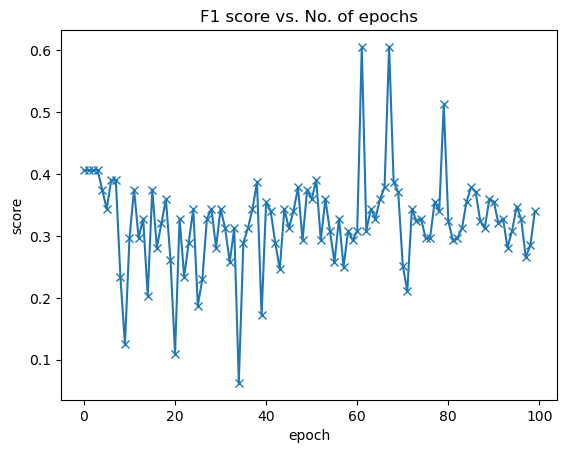

In [83]:
plot_scores(history)

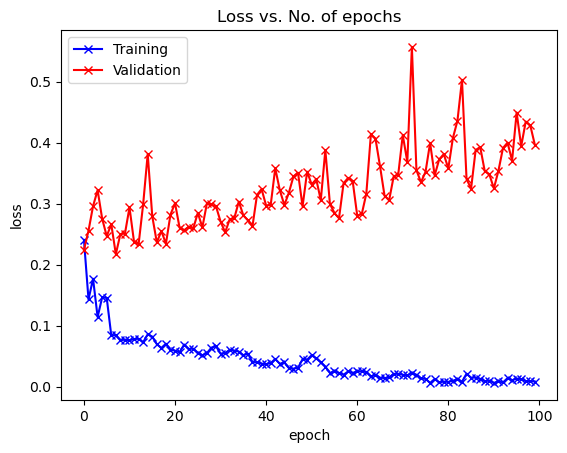

In [84]:
plot_losses(history)

# Testing

In [85]:
def show_example(img, pred_label, true_label=None):
    plt.imshow(img.permute(1,2,0))
    print("Predicted label:", decode_target(pred_label, idx2error))
    if true_label != None:
        print("True label:", decode_target(true_label, idx2error))
    print()
    print(pred_label)

def predict_single(image, label=None):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    show_example(image, prediction, label)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted label: ['']
True label: ['']

tensor([9.9197e-01, 5.1928e-04, 1.1022e-05, 1.3181e-07, 5.6655e-07, 1.2523e-03,
        3.2435e-08, 7.7671e-06, 3.1669e-08, 4.3418e-08, 5.8100e-08, 3.1740e-08,
        4.1948e-08, 7.5856e-09, 5.1669e-08, 3.4764e-08, 1.4823e-08, 3.5328e-08,
        8.3444e-09, 5.8617e-08, 4.1079e-07, 8.6081e-08, 2.4298e-08, 3.1946e-09],
       device='cuda:0', grad_fn=<SelectBackward0>)


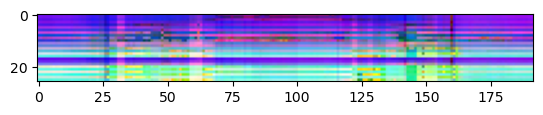

In [86]:
predict_single(test_ds[0][0], test_ds[0][1])

In [87]:
model.eval()
test_dl = DeviceDataLoader(test_loader, device)

test_losses = []
test_f1s = []
preds = []
trues = []
with torch.no_grad():
    for batch in test_dl:
        images, targets = batch 
        out = model(images)                           # Generate predictions
        loss = F.binary_cross_entropy(out, targets)   # Calculate loss
        score = F_score(out, targets)                 # Calculate accuracy
        test_losses.append(loss.detach().cpu().item())
        test_f1s.append(score.detach().cpu().item())
        preds.append(out.cpu().numpy())
        trues.append(targets.cpu().numpy())

In [88]:
preds_labels = []
for pred in preds:
    preds_labels.append((pred > THRESHOLD).astype(np.float32))

In [89]:
test_loss = np.mean(test_losses)
testf1 = np.mean(test_f1s)
print("Test BCE loss:", test_loss)
print("Test F1-score:", testf1)

Test BCE loss: 0.2562440164691008
Test F1-score: 0.5545454556291753


In [90]:
# exact match ratio
pred_ar = np.array(preds_labels)
trues_ar = np.array(trues)
assert pred_ar.shape==trues_ar.shape
emr = (trues_ar == pred_ar).astype(np.float32).sum() / trues_ar.size
print("Exact match ratio:", emr)

Exact match ratio: 0.9628787878787879


In [91]:
zeros_fraction = (trues_ar == 0).astype(np.float32).sum() / trues_ar.size
print("Zeros in data:", zeros_fraction)

Zeros in data: 0.9522727272727273


In [92]:
for i, predl in enumerate(preds_labels):
    if np.any((predl != trues[i])):
        print(i, "|should be", trues[i])
        print(i,"|predicted", predl)

1 |should be [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
1 |predicted [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
2 |should be [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
2 |predicted [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
3 |should be [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
3 |predicted [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
4 |should be [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
4 |predicted [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
7 |should be [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
7 |predicted [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
10 |should be [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
10 |predicted [[1. 0